In [29]:
# pyright: basic
from __future__ import annotations

from typing import Sequence

import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt

from tools import draw_plot

PathsOrPath = npt.NDArray[np.float64]

RNG = np.random.default_rng(1234)
YEARS = 25  # Time before retirement.

Use the S&P 500 total nominal returns from the data provided by Robert Shiller. Hopefully reduce bias in the data for particular months by creating rolling annual returns to sample from.

In [30]:
shiller = pd.read_excel("data/ie_data_own.xls", sheet_name="Data", skiprows=7)
# Just keep date and price columns
shiller = shiller[["Date", "Price.2"]]
shiller.columns = ["date", "nominal_total_return_price"]
# Drop nan at the end of the table
shiller.drop(shiller.index[-1], axis=0, inplace=True)
# Create rolling geometrically averaged annual returns.
returns = shiller["nominal_total_return_price"].pct_change()
log_returns = np.log(1 + returns)
annual_returns = np.exp(log_returns.rolling(12).sum()) - 1

sp500_total_returns = annual_returns.dropna().to_numpy()

A simple portfolio can be either one with a fixed allocation of a broad market equity asset and some safer asset (i.e. short duration goverment bonds), or a sliding allocation depending on the time.

In [31]:
def simple_portfolio(
    returns: PathsOrPath,
    safer_asset_allocation: float | PathsOrPath,
    safer_asset_returns: float = 0.02,
    years: int = 25,
    samples: int = 10000,
):
    sims = RNG.choice(returns, size=(samples, years))
    if callable(safer_asset_allocation):
        allocation = np.array([safer_asset_allocation(t, years) for t in range(years)])
        assert allocation.shape == (years,), allocation.shape
    else:
        allocation = safer_asset_allocation
    asset1 = (1 - allocation) * (sims + 1)
    asset2 = allocation * (safer_asset_returns + 1)
    return np.cumprod(asset1 + asset2, axis=1)

Andreas Beck's Global Portfolio One is using an interesting strategy of dynamically allocating more to equities when markets tank and otherwise returning to a 80% market, 20% safer asset split. In his e-book, he describes a DIY approach of staying 80%/20% by default and going 90%/10% when the market maximum drawdown reaches 20% or more, and 100%/0% when the market is down by more than 40%. This relies on downturns being a good time to buy.

In [32]:
def andreas_beck_portfolio(
    data: PathsOrPath,
    safer_asset_returns: float = 0.02,
    years: int = 25,
    samples: int = 10000,
):
    sims = RNG.choice(data, size=(samples, years)) + 1
    allocation = np.array([determine_allocations(x) for x in sims])
    asset1 = allocation * sims
    asset2 = (1 - allocation) * (safer_asset_returns + 1)
    return np.cumprod(asset1 + asset2, axis=1)


def determine_allocations(time_series: Sequence[float]) -> list[float]:
    allocation = []
    watermark = 1
    accumulator = 1
    for x in time_series:
        accumulator *= x
        watermark = max(watermark, accumulator)
        max_drawdown = (accumulator - watermark) / watermark
        if max_drawdown <= -0.4:
            allocation.append(1)
        elif max_drawdown <= -0.2:
            allocation.append(0.9)
        else:
            allocation.append(0.8)
    return allocation

Set baseline expectations of 5th percentile, median and 95th percentile returns in a standard S&P 500 buy and hold scenario without any other assets.

Average Growth Rate: 10.79%
95th Percentile Growth Rate: 15.38% (outcome: 3477%)
Median Growth Rate: 9.24% (outcome: 812%)
5th Percentile Growth Rate: 2.90% (outcome: 104%)


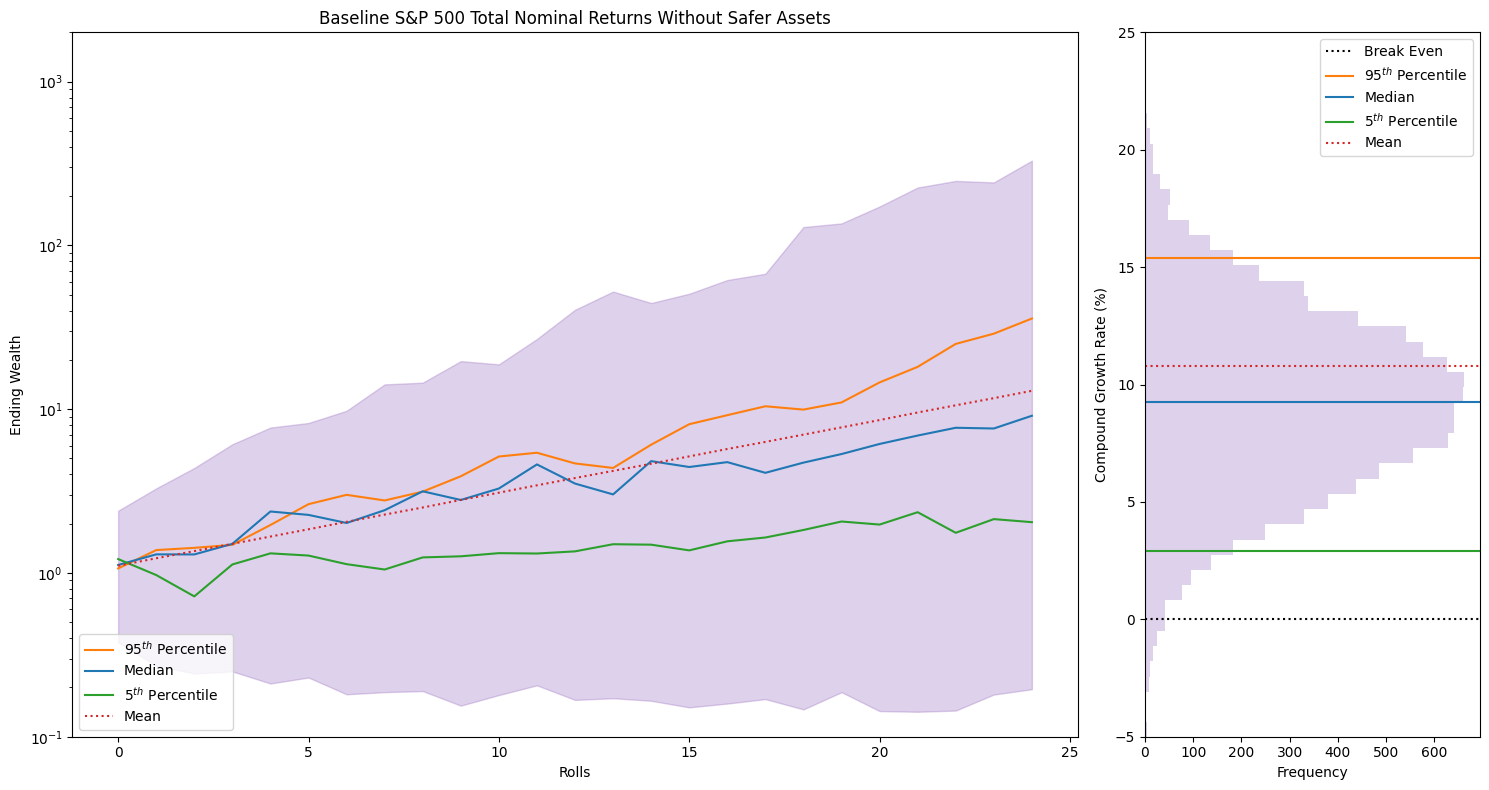

In [33]:
baseline = simple_portfolio(sp500_total_returns, years=YEARS, safer_asset_allocation=0)
draw_plot(baseline, "Baseline S&P 500 Total Nominal Returns Without Safer Assets", ylim_paths=(0.1, 2_000), ylim_cagr=(-5, 25))

See how it compares to a fixed 80%/20% variant with some safer asset.

Average Growth Rate: 9.06%
95th Percentile Growth Rate: 13.10% (outcome: 2069%)
Median Growth Rate: 8.02% (outcome: 588%)
5th Percentile Growth Rate: 2.89% (outcome: 104%)


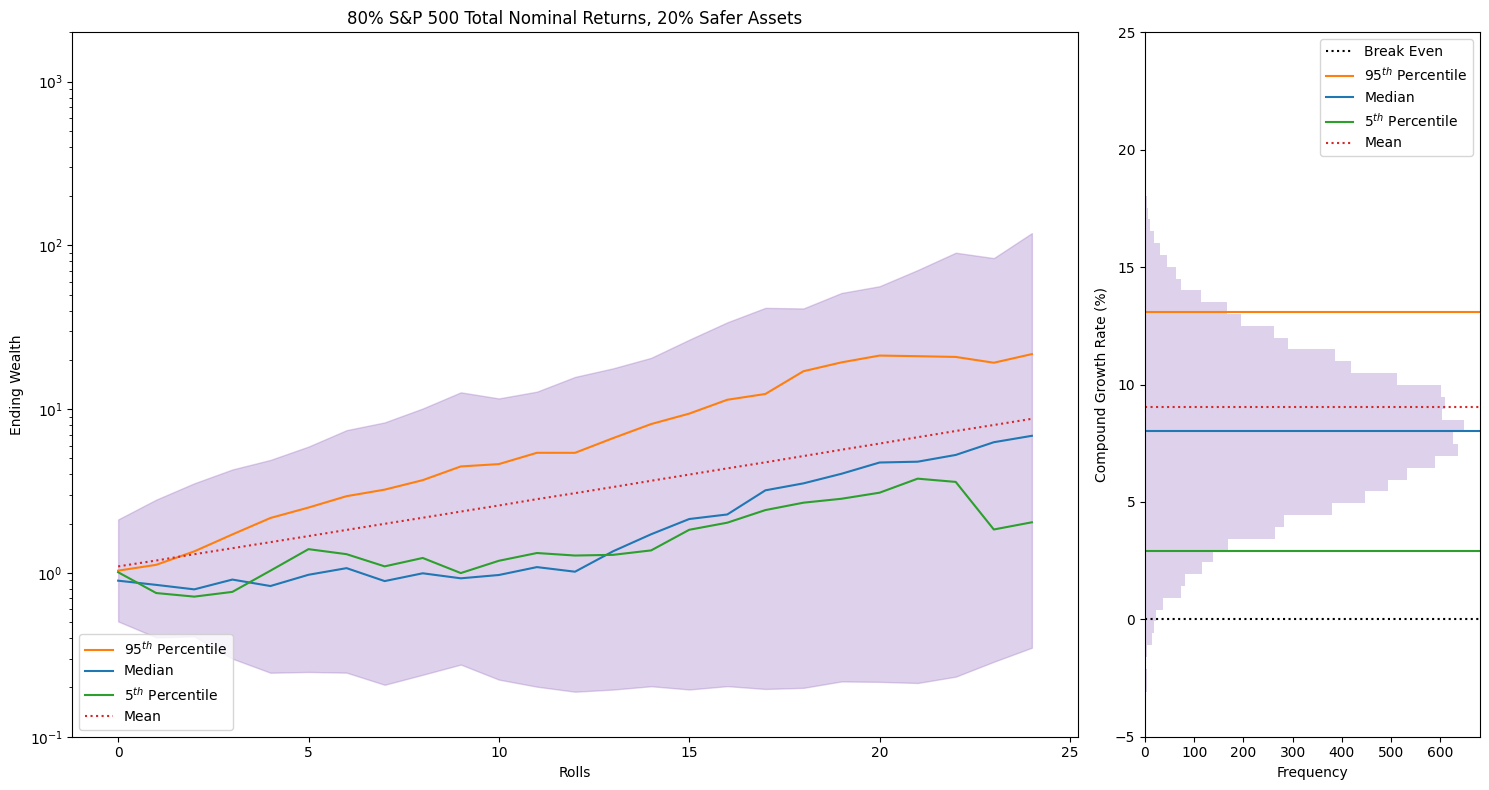

In [34]:
split_80_20 = simple_portfolio(sp500_total_returns, years=YEARS, safer_asset_allocation=0.2)
draw_plot(split_80_20, "80% S&P 500 Total Nominal Returns, 20% Safer Assets", ylim_paths=(0.1, 2_000), ylim_cagr=(-5, 25))

Test the Andreas Beck strategy. I suppose a Monte Carlo simulation without assumptions about distributions or behaviors won't make it look good.

Average Growth Rate: 8.84%
95th Percentile Growth Rate: 12.88% (outcome: 1969%)
Median Growth Rate: 7.70% (outcome: 538%)
5th Percentile Growth Rate: 2.24% (outcome: 74%)


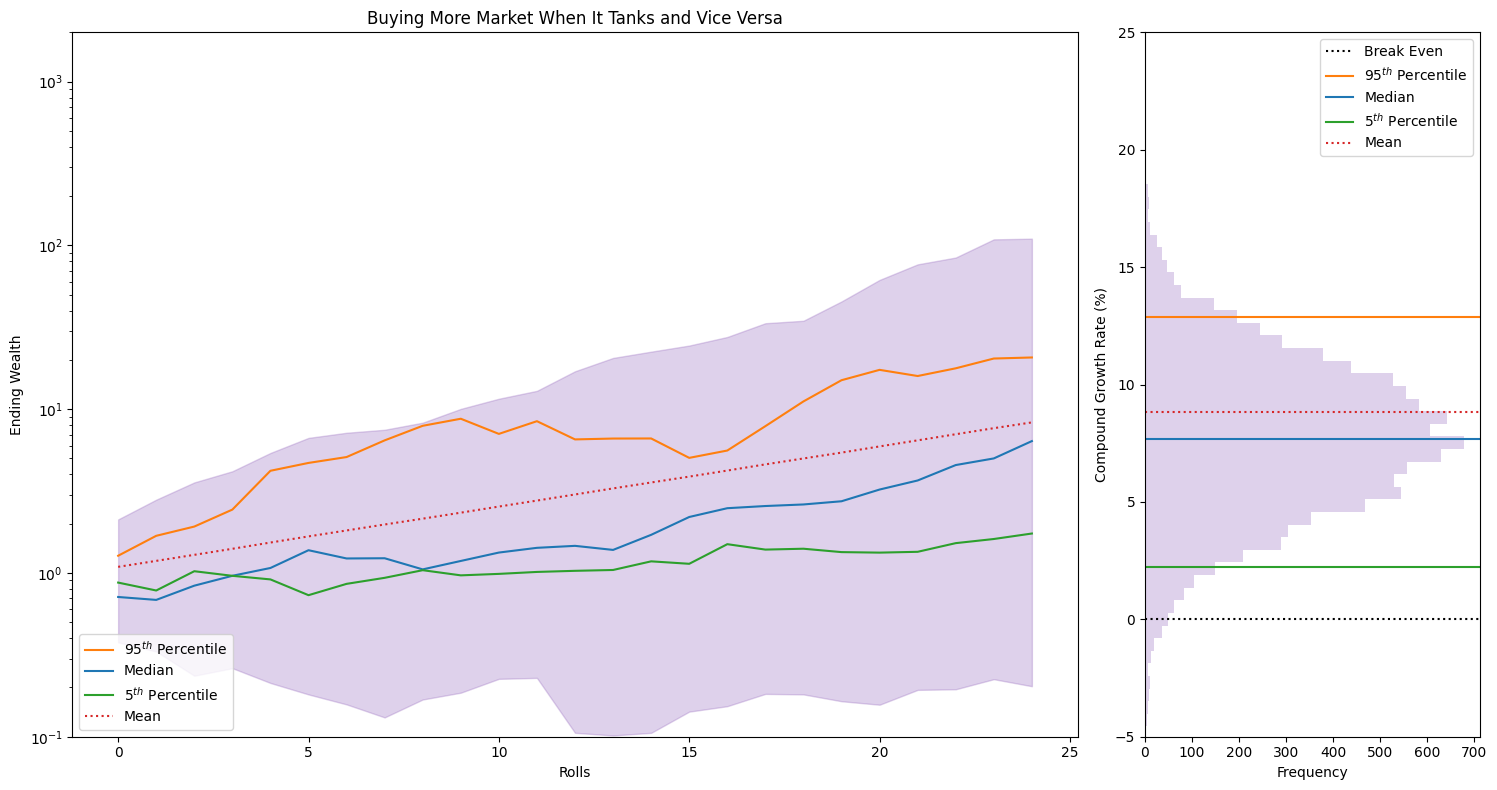

In [35]:
andreas_beck = andreas_beck_portfolio(sp500_total_returns, years=YEARS)
draw_plot(andreas_beck, "Buying More Market When It Tanks and Vice Versa", ylim_paths=(0.1, 2_000), ylim_cagr=(-5, 25))

Test a more realistic scenario of reducing exposure as you near retirement.

Average Growth Rate: 8.32%
95th Percentile Growth Rate: 12.03% (outcome: 1610%)
Median Growth Rate: 7.48% (outcome: 507%)
5th Percentile Growth Rate: 2.84% (outcome: 101%)


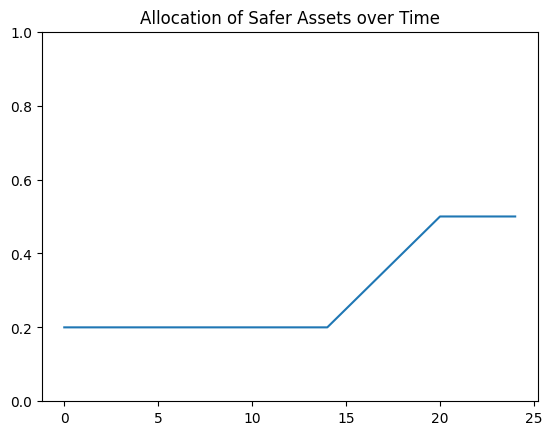

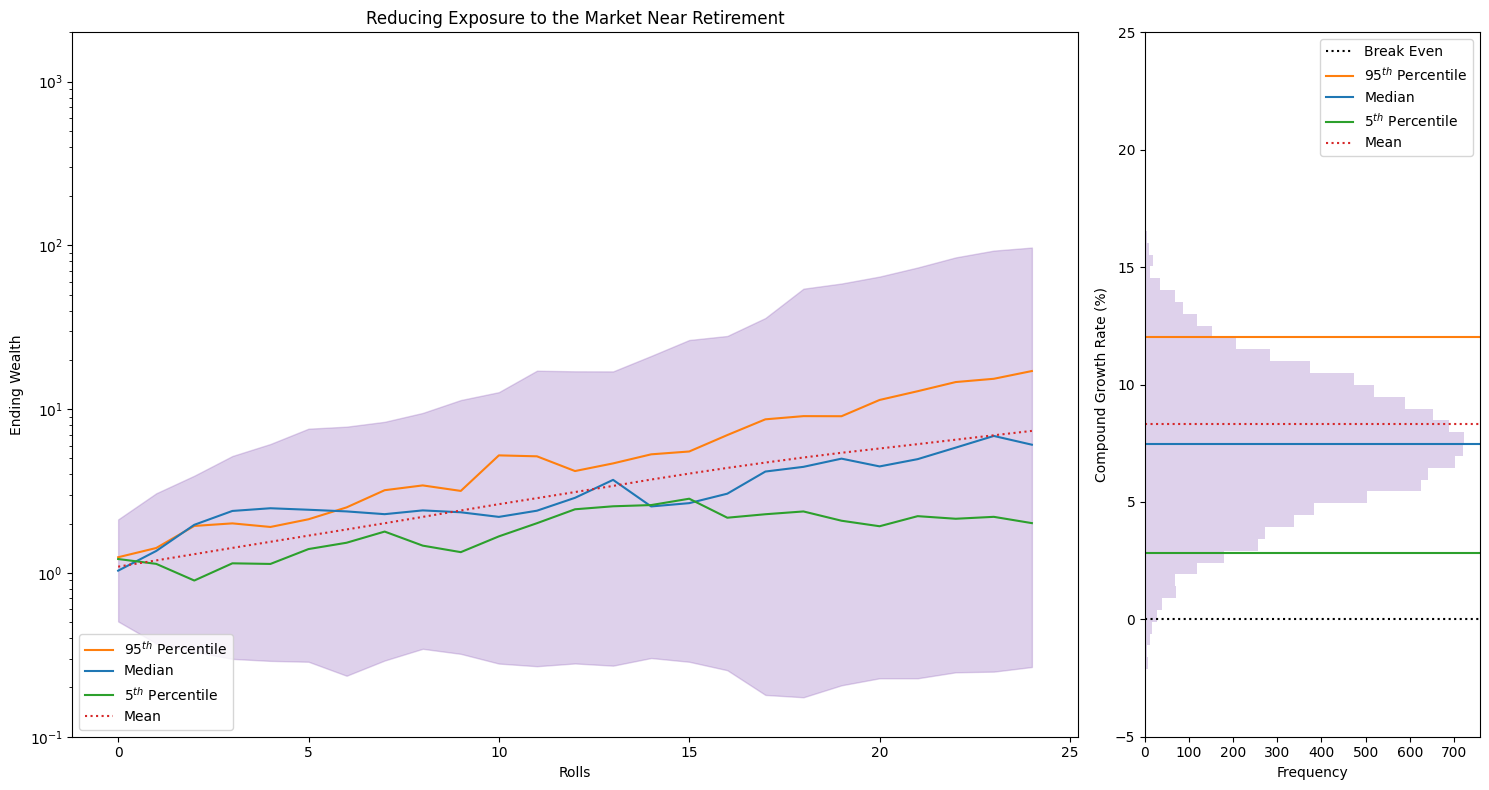

In [36]:
def mix(x: float, y: float, a: float) -> float:
    return x * (1 - a) + y * a


def allocation_slope(t: int, years: int) -> float:
    done = t / years
    if done < 0.6:
        return 0.2
    elif done < 0.8:
        return mix(0.25, 0.5, (done - 0.6) / 0.2)
    else:
        return 0.5

example_slope = [allocation_slope(t, YEARS) for t in range(YEARS)]
plt.plot(example_slope)
plt.ylim(0, 1)
plt.title("Allocation of Safer Assets over Time")

trajectories = simple_portfolio(
    sp500_total_returns, safer_asset_allocation=allocation_slope, years=YEARS
)
draw_plot(trajectories, "Reducing Exposure to the Market Near Retirement", ylim_paths=(0.1, 2_000), ylim_cagr=(-5, 25))

Average Growth Rate: 7.52%
95th Percentile Growth Rate: 10.80% (outcome: 1200%)
Median Growth Rate: 6.89% (outcome: 429%)
5th Percentile Growth Rate: 2.93% (outcome: 106%)


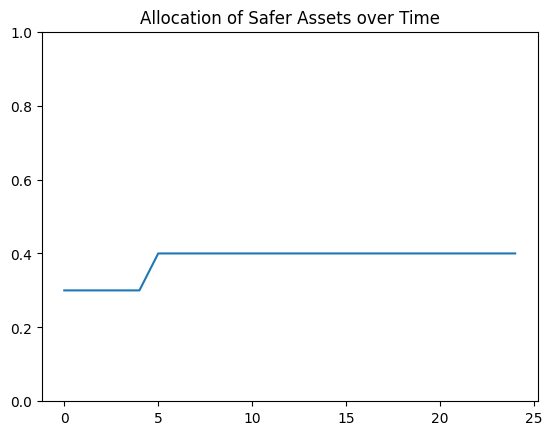

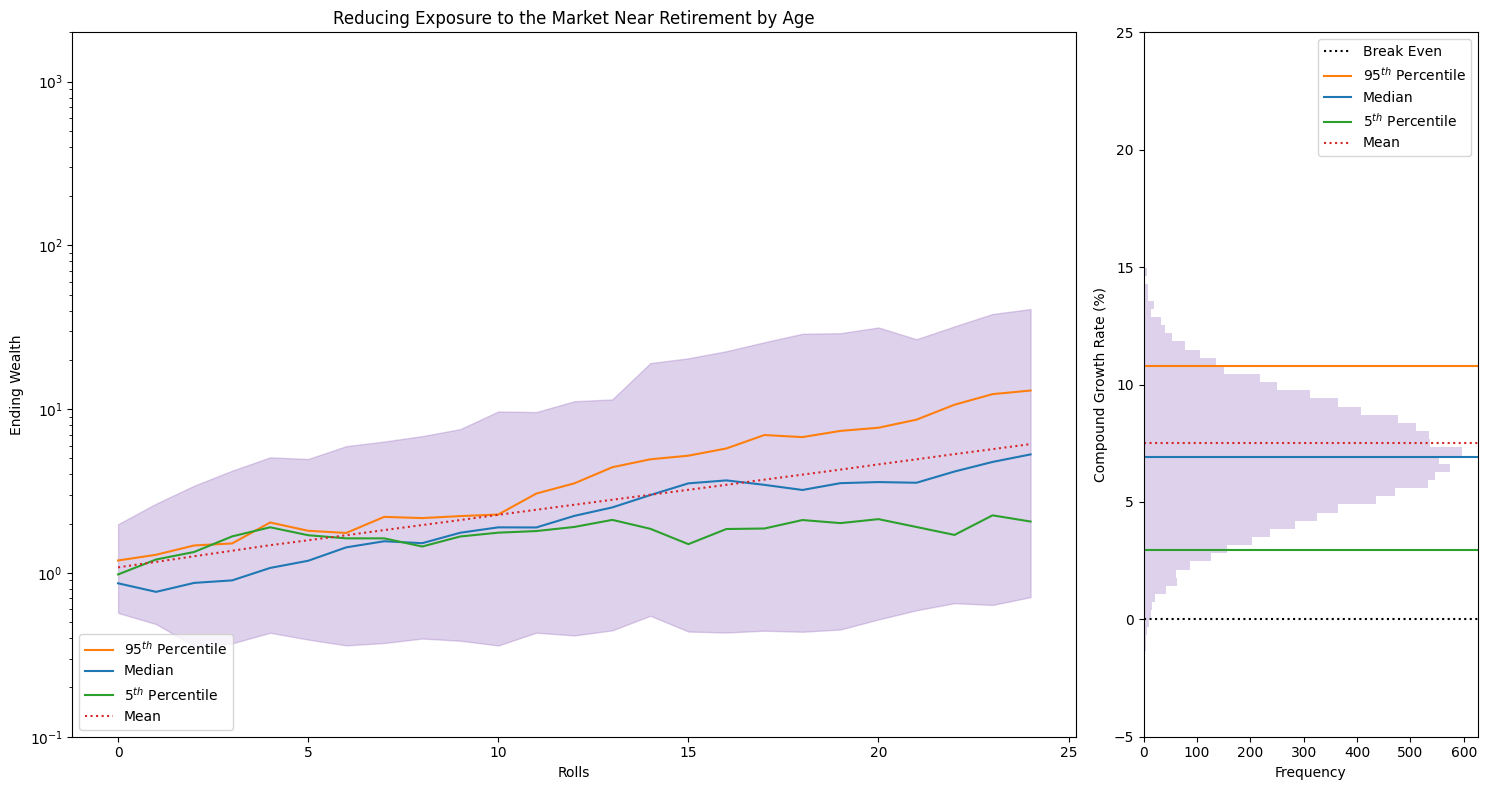

In [37]:
# Age at the end of the investing period.
retirement_age = 70


def allocation_slope_by_age(t: int, years: int) -> float:
    age = retirement_age - years + t
    if age < 20:  # Teens
        return 0
    elif age < 30:  # 20s
        return 0.1
    elif age < 40:  # 30s
        return 0.2
    elif age < 50:  # 40s
        return 0.3
    elif age < 70:  # 50s and 60s
        return 0.4
    else:  # 70s and beyond
        return 0.5


example_slope = [allocation_slope_by_age(t, YEARS) for t in range(YEARS)]
plt.plot(example_slope)
plt.ylim(0, 1)
plt.title("Allocation of Safer Assets over Time")

trajectories = simple_portfolio(
    sp500_total_returns, safer_asset_allocation=allocation_slope_by_age, years=YEARS
)
draw_plot(
    trajectories,
    "Reducing Exposure to the Market Near Retirement by Age",
    ylim_paths=(0.1, 2_000),
    ylim_cagr=(-5, 25),
)

Average Growth Rate: 7.84%
95th Percentile Growth Rate: 11.37% (outcome: 1375%)
Median Growth Rate: 7.05% (outcome: 450%)
5th Percentile Growth Rate: 2.70% (outcome: 94%)


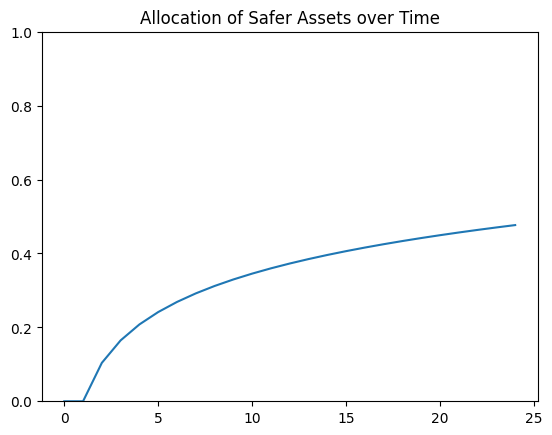

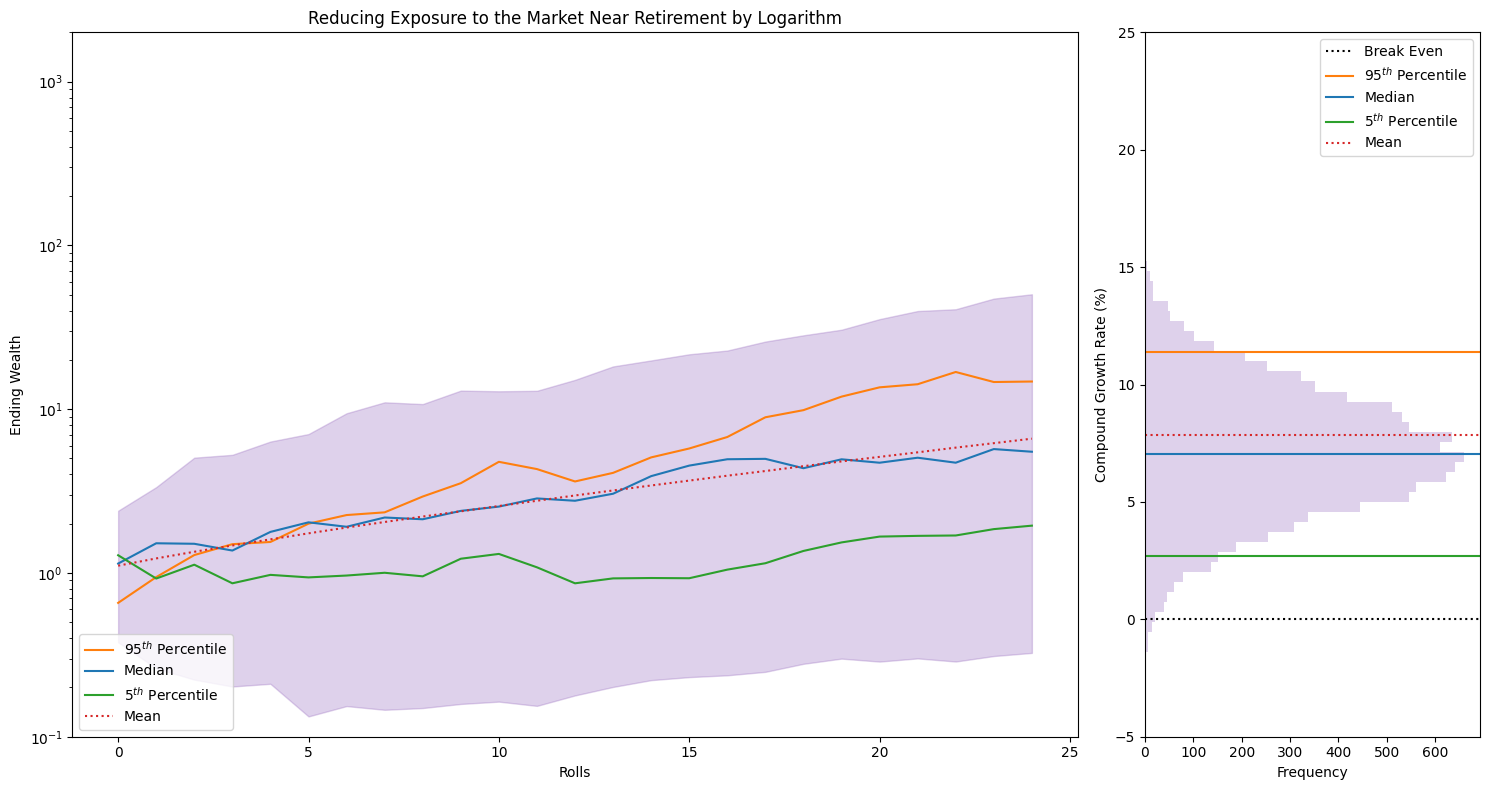

In [38]:
import math

def allocation_slope_by_log(t: int, years: int) -> float:
    if t == 0:
        return 0
    return 0.15 * math.log(t)


example_slope = [allocation_slope_by_log(t, YEARS) for t in range(YEARS)]
plt.plot(example_slope)
plt.ylim(0, 1)
plt.title("Allocation of Safer Assets over Time")

trajectories = simple_portfolio(
    sp500_total_returns, safer_asset_allocation=allocation_slope_by_log, years=YEARS
)
draw_plot(
    trajectories,
    "Reducing Exposure to the Market Near Retirement by Logarithm",
    ylim_paths=(0.1, 2_000),
    ylim_cagr=(-5, 25),
)